# 01 — Quickstart: real-world data + Cleanlab (comparison)

This notebook demonstrates an end-to-end workflow:

1. Download a real-world dataset automatically.
2. Train multiple model variants (baseline vs Cleanlab-enabled variants).
3. Use Cleanlab to find label issues + dataset issues (outliers / near-duplicates / non-iid).
4. Retrain after pruning flagged issues and compare metrics.


In [1]:
from pathlib import Path
import sys

# Make `src/` importable when running in PyCharm/Jupyter
cwd = Path.cwd()
if (cwd / "src").exists():
    sys.path.insert(0, str(cwd / "src"))
elif (cwd.parent / "src").exists():
    sys.path.insert(0, str(cwd.parent / "src"))


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from cleanlab_demo.config import (
    CleanlabConfig,
    DatasetName,
    DemoConfig,
    ModelConfig,
    ModelName,
    RunConfig,
)
from cleanlab_demo.data import DatasetHub
from cleanlab_demo.experiments import run_experiment
from cleanlab_demo.settings import settings

sns.set_theme(style="whitegrid")
settings.ensure_dirs()


## 1) Download + inspect dataset

In [3]:
hub = DatasetHub(settings.data_dir)
ds = hub.load(DatasetName.adult_income)
df = ds.df
target_col = ds.target_col
df.shape, target_col


((32561, 15), 'income')

In [4]:
df.head(5)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
# Basic data quality snapshot
missing = (df.isna().mean().sort_values(ascending=False) * 100).round(2)
missing.head(15)


occupation        5.66
workclass         5.64
native_country    1.79
fnlwgt            0.00
education         0.00
education_num     0.00
age               0.00
marital_status    0.00
relationship      0.00
sex               0.00
race              0.00
capital_gain      0.00
capital_loss      0.00
hours_per_week    0.00
income            0.00
dtype: float64

In [6]:
df[target_col].value_counts(normalize=True).mul(100).round(2)


income
<=50K    75.92
>50K     24.08
Name: proportion, dtype: Float64

## 2) Run one experiment (baseline + Cleanlab variants)

We run a single configuration that returns multiple variants:

- `baseline`: normal training
- `pruned_retrain`: retrain after pruning flagged issues (label issues for classification; label/outliers for regression)
- `cleanlearning` (optional): Cleanlab `CleanLearning` model (classification-only)


In [7]:
cfg = RunConfig(
    dataset=DatasetName.adult_income,
    model=ModelConfig(name=ModelName.hist_gradient_boosting),
    demo=DemoConfig(max_rows=12000, label_noise_fraction=0.05),
    cleanlab=CleanlabConfig(
        enabled=True,
        use_datalab=True,
        datalab_fast=True,
        prune_and_retrain=True,
        prune_fraction=0.02,
        train_cleanlearning=False,
        cv_folds=3,
        max_issues=200,
    ),
)

result = run_experiment(cfg)
result.task, result.model


2026-02-08 02:30:34 | INFO     | cleanlab_demo | Loading dataset: adult_income
2026-02-08 02:30:34 | INFO     | cleanlab_demo | Dataset loaded: 12,000 rows
/Users/rezami/PycharmProjects/Cleanlab_demo/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(<TaskType.classification: 'classification'>,
 <ModelName.hist_gradient_boosting: 'hist_gradient_boosting'>)

### Variant comparison

In [8]:
variants_df = pd.DataFrame(
    [
        {
            "variant": v.variant.value,
            "n_train": v.n_train,
            "primary": v.metrics.primary,
            **(v.metrics.details or {}),
            **(v.notes or {}),
        }
        for v in result.variants
    ]
).sort_values("primary", ascending=False)

baseline_primary = float(variants_df.loc[variants_df["variant"] == "baseline", "primary"].iloc[0])
variants_df["delta_vs_baseline"] = variants_df["primary"].astype(float) - baseline_primary
variants_df


,variant,n_train,primary,accuracy,f1_weighted,roc_auc,n_pruned,delta_vs_baseline
1,pruned_retrain,9408,0.914722,0.869167,0.864578,0.914722,192.0,0.004881
0,baseline,9600,0.909842,0.866250,0.861294,0.909842,NaN,0.000000


<Axes: title={'center': 'Primary metric by variant'}, xlabel='variant', ylabel='primary'>

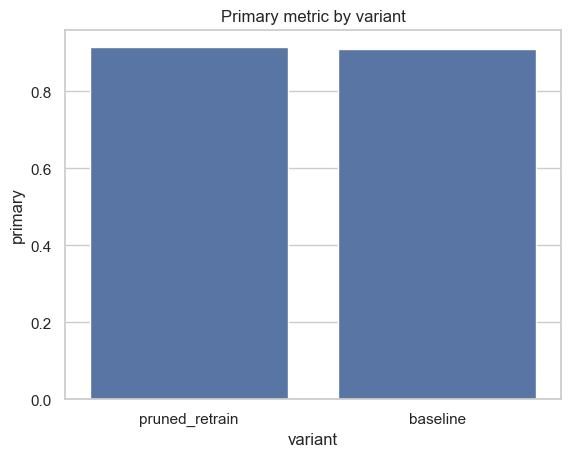

In [9]:
ax = sns.barplot(data=variants_df, x="variant", y="primary")
ax.set_title("Primary metric by variant")
ax


## 3) Label issues

These are the top-ranked potential label issues (lower `score` = more suspicious).

In [10]:
issues_df = pd.DataFrame([li.model_dump() for li in result.label_issues])
issues_df.head(20)


,index,label,suggested_label,score
0,7265,>50K,<=50K,0.003853
1,6952,<=50K,>50K,0.005397
2,5243,>50K,<=50K,0.005775
3,238,>50K,<=50K,0.006723
4,2670,>50K,<=50K,0.006971
5,2561,>50K,<=50K,0.007932
6,945,>50K,<=50K,0.008335
7,8977,>50K,<=50K,0.009311
8,209,>50K,<=50K,0.010373
9,2208,<=50K,>50K,0.010941


## 4) Datalab dataset issues (outliers / near-duplicates / non-iid)

The issue summary shows what Datalab detected in the training split.

In [11]:
datalab_summary = result.cleanlab_summary.get("datalab_issue_summary")
pd.DataFrame(datalab_summary) if datalab_summary else result.cleanlab_summary


,issue_type,score,num_issues
0,label,0.908229,1178
1,outlier,0.414294,79
2,near_duplicate,0.563855,1528
3,non_iid,0.881378,0


In [12]:
examples = result.cleanlab_summary.get("datalab_examples", {})
list(examples.keys()), list(examples.get("outlier", [])[:2])


(['label', 'outlier', 'near_duplicate', 'non_iid'],
 [{'train_row': 4000,
   'outlier_score': 0.024573642361771113,
   'row': {'age': 42,
    'workclass': 'Local-gov',
    'fnlwgt': 195124,
    'education': '11th',
    'education_num': 7,
    'marital_status': 'Divorced',
    'occupation': 'Sales',
    'relationship': 'Unmarried',
    'race': 'White',
    'sex': 'Male',
    'capital_gain': 7430,
    'capital_loss': 0,
    'hours_per_week': 50,
    'native_country': 'Puerto-Rico'}},
  {'train_row': 6232,
   'outlier_score': 0.024673544001419013,
   'row': {'age': 31,
    'workclass': 'Self-emp-not-inc',
    'fnlwgt': 162551,
    'education': '12th',
    'education_num': 8,
    'marital_status': 'Married-civ-spouse',
    'occupation': 'Sales',
    'relationship': 'Wife',
    'race': 'Asian-Pac-Islander',
    'sex': 'Female',
    'capital_gain': 0,
    'capital_loss': 0,
    'hours_per_week': 50,
    'native_country': None}}])

## 5) Save artifacts

We save the last result so the Streamlit UI and the PydanticAI report notebook can reuse it.

In [13]:
artifacts = settings.artifacts_dir
artifacts.mkdir(exist_ok=True)
result_path = artifacts / "last_result.json"
result_path.write_text(result.model_dump_json(indent=2), encoding="utf-8")
result_path


PosixPath('artifacts/last_result.json')